## Considerations

Dataset extracted from https://snap.stanford.edu/data/amazon0302.html
- Amazon network https://snap.stanford.edu/data/amazon0302.html
- Metadata https://snap.stanford.edu/data/amazon-meta.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-igraph==0.9.6
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=739d984fc8fc9105154d9b8e98e38bb15a30af503e0e4c08be6b27e1cbd7faa3
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


## Importings

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import time
import itertools
import warnings
import pickle

warnings.filterwarnings('ignore')

## Dataset

### Metadata

Treating metadata and organizing into a pandas dataframe

In [ ]:
# # read all lines of the meta data into content list
# with open('amazon-meta.txt', encoding='utf8') as f:
#     content = f.readlines()

In [ ]:
# remove the beginning and trailing white spaces
# content = [x.strip() for x in content]

In [ ]:
# # Write extracted information to testfile.txt in a format of ',' demilited files.
# # The columns are Id, title, group, categories, totalreviews, avgrating.
# # The code stores all extracted information about a product into previoulines,
# # and write the content into file only when all information are available. Hence,
# # if review information for a product is not available, the product won't appear
# # in the final file.
# file = open("testfile.txt","w", encoding='utf8')
# previouslines = ['Id', 'title', 'group', 'categories', 'totalreviews', 'avgrating']
# for line in content:
#     lines = line.split(':')
#     if lines[0] == "Id":
#         if (len(previouslines) == 6):
#             for component in previouslines[0:5]:
#                 file.write(component)
#                 file.write(',')
#             file.write(previouslines[5])
#             file.write("\n")
#         previouslines = []
#         previouslines.append(lines[1].strip())
        
#     if lines[0] == "title":
#         title = ':'.join(lines[1:]).strip().replace(',', ' ').replace('\n', ' ').strip()
#         previouslines.append(title)
       
#     if lines[0] == "group":
#         previouslines.append(lines[1].strip())

#     if lines[0] == "categories":
#         previouslines.append(lines[1].strip())
    
#     if lines[0] == "reviews" and lines[1].strip() == "total":
#         previouslines.append(lines[2].split(' ')[1])
#         previouslines.append(lines[4].strip())
# file.close()

In [ ]:
# metadata
desc = pd.read_csv('drive/MyDrive/testfile.txt')

In [ ]:
desc.head()

,Id,title,group,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,2,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,2,0,0.0


#### EDA

In [ ]:
desc.nunique()

Id              542683
title           499796
group               10
categories          90
totalreviews       958
avgrating           10
dtype: int64

In [ ]:
desc['group'].value_counts()

Book            393561
Music           103143
Video            26131
DVD              19828
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: group, dtype: int64

In [ ]:
desc = desc[desc['group'].isin(['Book', 'Music', 'DVD', 'Video'])]

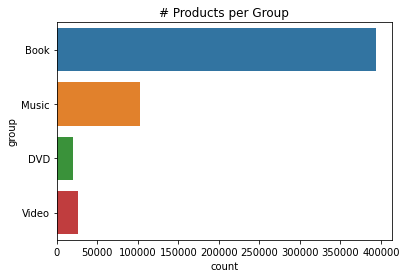

In [ ]:
sns.countplot(data=desc, y='group').set(title='# Products per Group');

In [ ]:
desc.head(2)

,Id,title,group,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,2,12,4.5


In [ ]:
desc[['totalreviews', 'avgrating']].corr()

,totalreviews,avgrating
totalreviews,1.000000,0.093652
avgrating,0.093652,1.000000


[Text(0, 0.5, 'ratingvalue'),
 Text(0.5, 0, 'avgrating/productgroup'),
 Text(0.5, 1.0, 'Rating per Group')]

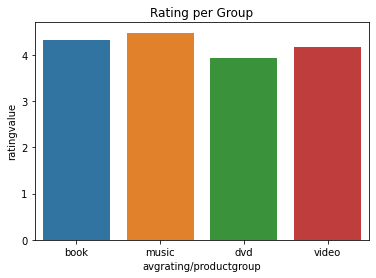

In [ ]:
ratingdesc = desc[desc.avgrating != 0]

bookdesc = ratingdesc[ratingdesc.group.eq('Book')]
musicdesc = ratingdesc[ratingdesc.group.eq('Music')]
dvddesc = ratingdesc[ratingdesc.group.eq('DVD')]
videodesc = ratingdesc[ratingdesc.group.eq('Video')]

avgratings_group = {
    'book': bookdesc['avgrating'].mean(),
    'music': musicdesc['avgrating'].mean(),
    'dvd': dvddesc['avgrating'].mean(),
    'video': videodesc['avgrating'].mean()
}

keys = list(avgratings_group.keys())
vals = [avgratings_group[k] for k in avgratings_group.keys()]

ax = sns.barplot(x=keys, y=vals)
ax.set(xlabel='avgrating/productgroup', ylabel='ratingvalue',title='Rating per Group')

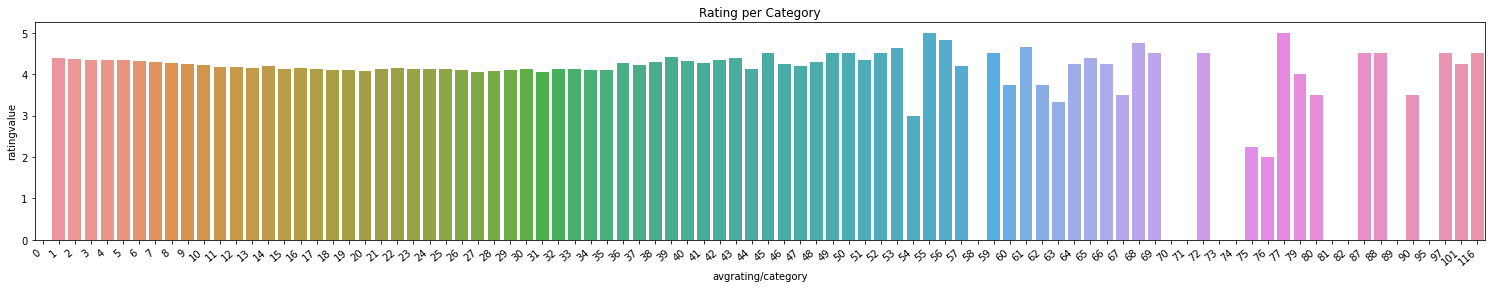

In [ ]:
categories = desc['categories'].unique()

avgratings_cat = {}

for i in categories: 
  key = i
  value = ratingdesc[ratingdesc.categories.eq(i)]['avgrating'].mean()
  avgratings_cat[key] = value 

keys = list(avgratings_cat.keys())
vals = [avgratings_cat[k] for k in avgratings_cat.keys()]

plt.figure(figsize=(26,4))
ax = sns.barplot(x=keys, y=vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Rating per Category', xlabel='avgrating/category', ylabel='ratingvalue')
plt.show()

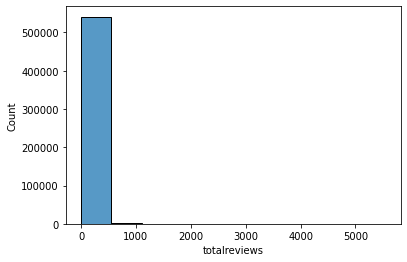

In [ ]:
sns.histplot(data=desc, x='totalreviews', bins=10);

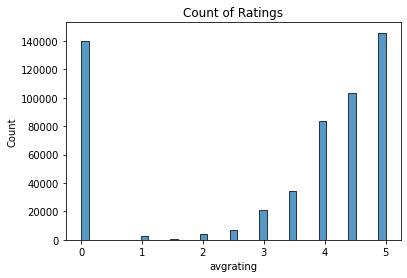

In [ ]:
sns.histplot(data=desc, x='avgrating').set(title='Count of Ratings');

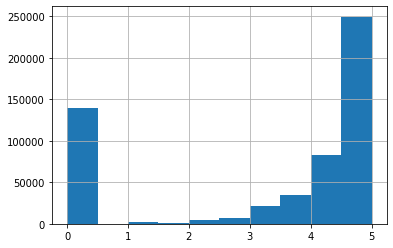

In [ ]:
desc['avgrating'].hist()

### Network

Reading dataframe and merging with metadata information

In [ ]:
df = pd.read_csv('drive/MyDrive/Amazon0302.txt', skiprows=4, header=None, sep='\t', names=['from', 'to'])

In [ ]:
# Join the link data with the meta data. The joined data contains the description for
# from node product as well as to node product.
df = (
    df
    .merge(desc, left_on=['from'], right_on=['Id'], suffixes=['.1', '.from'])
    .merge(desc, left_on=['to'], right_on=['Id'], suffixes=['.from', '.to'])
)

In [ ]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## EDA

Basic exploratory analysis

In [ ]:
print('Unique titles:', desc['title'].nunique())
print('Unique Categories:', desc['categories'].nunique())

Unique titles: 499776
Unique Categories: 90


In [ ]:
desc['group'].value_counts()

Book     393561
Music    103143
Video     26131
DVD       19828
Name: group, dtype: int64

In [ ]:
df.shape

(1207262, 14)

In [ ]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## Creating graph

### Vertices

In [ ]:
df.head(2)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


In [ ]:
# creating weight for edges
# avgrating performed better and indicates the strenght of higher ratings

df['same_category'] = np.where(df['categories.from']==df['categories.to'], 1, 0)
df['avgrating'] = df['avgrating.from'] * df['avgrating.to']

In [ ]:
g = ig.Graph.DataFrame(df[['from', 'to', 'same_category', 'avgrating']], directed=False)

In [ ]:
g.summary()

'IGRAPH UN-- 259092 1207262 -- \n+ attr: name (v), avgrating (e), same_category (e)'

In [ ]:
g.vs.attribute_names()

['name']

In [ ]:
degree = pd.DataFrame({
    'degree': g.degree()
}) 

avgdegree = degree.degree.mean()
print(avgdegree)

9.319176199959859


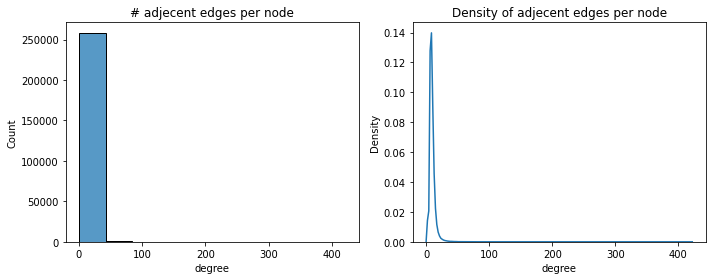

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=degree, x='degree', bins=10, ax=ax[0]).set(title='# adjecent edges per node')
sns.kdeplot(data=degree, x='degree', ax=ax[1]).set(title='Density of adjecent edges per node')
plt.tight_layout();

## Clustering

Selecting only the highest connected network

In [ ]:
cc = g.clusters(mode='weak')
print('# connected components', len(cc))

# connected components 22


In [ ]:
cc = np.array(
    sorted(cc, key=len, reverse=True), dtype='object'
)

In [ ]:
print('Top 5 connected networks')
[len(cc[i]) for i in range(5)]

Top 5 connected networks


[258958, 22, 15, 13, 11]

In [ ]:
g = g.subgraph(cc[0])

Trying different community detection algorithms without and with the weights created

### Fast-Greedy


### Leiden

In [ ]:
start = time.time()
coms_leid_raw = g.community_leiden()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_raw.modularity)

Time elapsed: 0.00029754638671875
Modularity: 0.45999999999999996


In [ ]:
start = time.time()
coms_leid_w = g.community_leiden(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_w.modularity)

Time elapsed: 0.0002987384796142578
Modularity: 0.6494778981551469


### Louvain

In [ ]:
start = time.time()
coms_louv_raw = g.community_multilevel()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_raw.modularity)

Time elapsed: 6.364372968673706
Modularity: 0.9157831188600234


In [ ]:
start = time.time()
coms_louv_w = g.community_multilevel(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_w.modularity)

Time elapsed: 8.057715892791748
Modularity: 0.929795954620142


### Infomap

In [ ]:
# start = time.time()
# coms_info_raw = g.community_infomap()
# print('Time elapsed:', time.time() - start)
# print('Modularity:', coms_info_raw.modularity)

In [ ]:
# start = time.time()
# coms_info_w = g.community_infomap(edge_weights=g.es['avgrating'])
# print('Time elapsed:', time.time() - start)
# print('Modularity:', coms_info_w.modularity)

### Save community

In [ ]:
# coms = {
#     'leiden_raw': coms_leid_raw,
#     'leiden_weighted': coms_leid_w,
#     'louvain_raw': coms_louv_raw,
#     'louvain_weighted': coms_louv_w,
#     'infomap_raw': coms_info_raw,
#     'infomap_weighted': coms_info_w
# }

In [ ]:
# with open('coms.pkl', 'wb') as f:
#     pickle.dump(coms, f)

with open('drive/MyDrive/coms.pkl', 'rb') as f:
    coms = pickle.load(f)

## Evaluating clusters

In [ ]:
df_coms = pd.DataFrame({
    'Id': g.vs()['name'],
    'degree': g.degree(),
    'transitivity': g.transitivity_local_undirected()
})

names = ['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']

In [ ]:
for i, j in coms.items():
    df_coms[i] = j.membership

hubdom = {}
for i in names:
  df = df_coms[['Id',f'{i}', 'degree', 'transitivity']]
  df['count'] = df.groupby(f'{i}')[f'{i}'].transform('size')

  df['degree_value'] = df['degree'] / df['count']

  df = df.loc[df.groupby(f'{i}')['degree_value'].idxmax()]
  df['hubdom_value'] = (df['degree_value']-df['degree_value'].min())/(df['degree_value'].max()-df['degree_value'].min())

  hubdom.update({f'{i}-hub':df})

#### Create scatterplot to show hub dominance with respect to transitivity

In [ ]:
print(hubdom['leiden_raw-hub'])


              Id  leiden_raw  degree  transitivity  count  degree_value  \
0            1.0           0       4      0.000000      1           4.0   
1            2.0           1       5      0.100000      1           5.0   
2            3.0           2       5      0.600000      1           5.0   
3            4.0           3      29      0.113960      5           5.8   
4            5.0           4      58      0.052525      5          11.6   
...          ...         ...     ...           ...    ...           ...   
258952  262104.0      113839       5      0.666667      1           5.0   
258953  262106.0      113840       7      0.800000      1           7.0   
258954  262107.0      113841       8      0.733333      2           4.0   
258955  262108.0      113842       6      0.900000      1           6.0   
258956  262109.0      113843       6      0.866667      1           6.0   

        hubdom_value  
0           0.010949  
1           0.014599  
2           0.014599  
3      

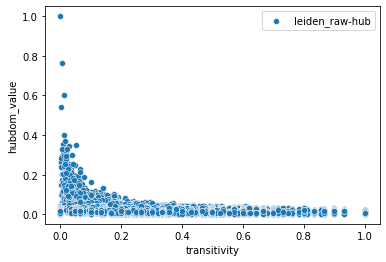

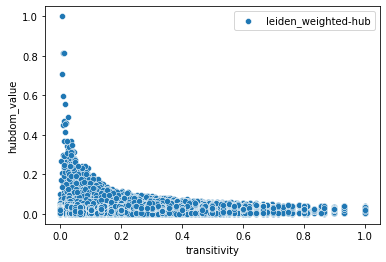

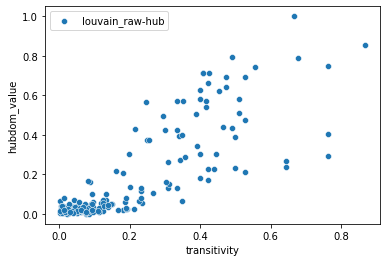

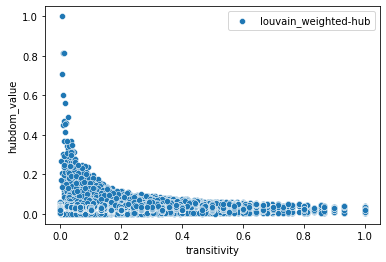

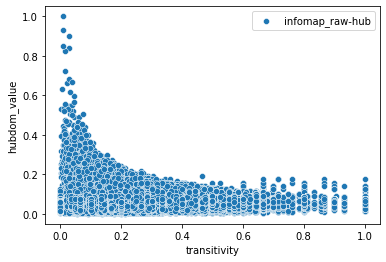

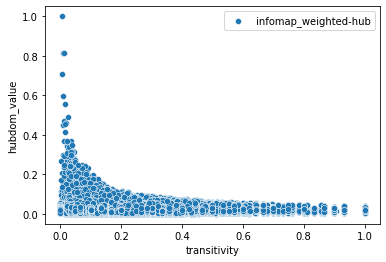

In [ ]:
for k,v in hubdom.items():
  plt.figure(k)
  sns.scatterplot(data=hubdom[f'{k}'], x="transitivity", y="hubdom_value", label=k)

In [ ]:
# df_coms = pd.DataFrame({
#     'Id': g.vs()['name'],
#     names[0]: coms[0].membership,
#     names[1]: coms[1].membership,
#     names[2]: coms[2].membership,
#     names[3]: coms[3].membership,
#     names[4]: coms[4].membership,
#     names[5]: coms[5].membership
# })

In [ ]:
df_coms_summary = pd.DataFrame({
    'modularity': [i.modularity for i in coms.values()],
    'communities': [len(set(i.membership)) for i in coms.values()]
}, index=names).sort_values('modularity')

In [ ]:
df_coms_summary

,modularity,communities
infomap_raw,0.238708,82429
infomap_weighted,0.305514,119043
leiden_raw,0.412101,113844
leiden_weighted,0.801689,92377
louvain_raw,0.915548,198
louvain_weighted,0.930238,72698


**Louvain** weighted presented the highest modularity and showed 72698 communities (to be checked)

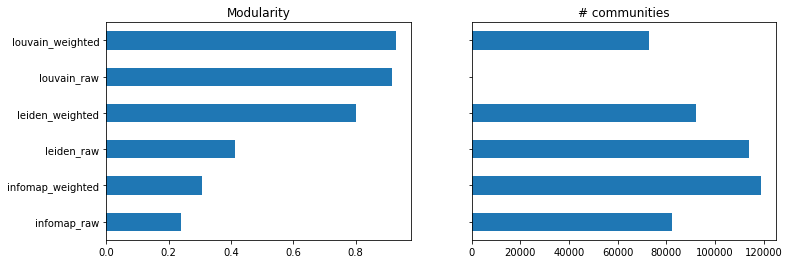

In [ ]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

df_coms_summary['modularity'].plot.barh(title='Modularity', ax=ax[0])
df_coms_summary['communities'].plot.barh(title='# communities', ax=ax[1]);

We can compare the nmi and adjusted rand between the communities created

In [ ]:
comb_names_1 = []
comb_names_2 = []
comb_nmi = []
comb_rand = []

for n, c in zip(itertools.combinations(coms.keys(), 2), itertools.combinations(coms.values(), 2)):
    comb_names_1.append(f'{n[0]}')
    comb_names_2.append(f'{n[1]}')
    comb_nmi.append(ig.compare_communities(c[0], c[1], method='nmi'))
    comb_rand.append(ig.compare_communities(c[0], c[1], method='adjusted_rand'))

KeyboardInterrupt: ignored

In [ ]:
df_comb = pd.DataFrame({
    'algorithm_1': comb_names_1,
    'algorithm_2': comb_names_2,
    'nmi': comb_nmi,
    'adjusted_rand': comb_rand
}, index=comb_names_1).sort_values('nmi')

df_comb

In [ ]:
resultnmi = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='nmi')

print(resultnmi)

resultnmi = resultnmi[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultnmi = resultnmi.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultnmi, annot=True, fmt="g", cmap='Blues')
ax.set(title='NMI Heatmap', xlabel='detection algorithms', ylabel='detection algorithms')

In [ ]:
resultrand = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='adjusted_rand').round(decimals=2)

print(resultrand)

resultrand = resultrand[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultrand = resultrand.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultrand, annot=True, fmt="g", cmap='Blues')
ax.set(title='Adjusted Rand Heatmap', xlabel='detection algorithms', ylabel='detection algorithms')

In [ ]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
df_comb['nmi'].plot.barh(title='NMI', ax=ax[0])
df_comb['adjusted_rand'].plot.barh(title='Adjusted rand', ax=ax[1]);

## Louvaing weighted

Selecting the highest community of louvain weighted

In [ ]:
g_giant_louv_w = coms['louvain_weighted'].giant()

In [ ]:
df_giant_louv_w = pd.DataFrame({
    'Id': g_giant_louv_w.vs['name'],
    'degree': g_giant_louv_w.degree(),
    'betweenness': g_giant_louv_w.betweenness(),
    'clustering_coefficient': g_giant_louv_w.transitivity_local_undirected()
})

In [ ]:
df_giant_louv_w['Id'] = df_giant_louv_w['Id'].astype(int)

In [ ]:
df_giant_louv_w = df_giant_louv_w.merge(desc, on='Id')

In [ ]:
df_giant_louv_w.shape

We can check the products of the highest community 

In [ ]:
df_giant_louv_w[
    (df_giant_louv_w['betweenness'] > np.quantile(df_giant_louv_w['betweenness'], 0.95)) &
    (df_giant_louv_w['degree'] > np.quantile(df_giant_louv_w['degree'], 0.95))
]

In [ ]:
sns.pairplot(data=df_giant_louv_w[['degree', 'betweenness', 'clustering_coefficient', 'group']], hue='group')

## Visualization

In [ ]:
# considering the top 2nd most connected network
g_sub = g.subgraph(cc[1])

In [ ]:
layout_fr = g_sub.layout('fr')

visual_style = {
    #Define style from network plotting
    "vertex_size": 5,
    "vertex_color": 'orange',
    "edge_arrow_size": 0.5,
    "edge_width":0.5,
    "vertex_label": None,
    "layout": layout_fr,
    "bbox": (600, 600),
    "edge_width": 1
}

ig.plot(g_sub, **visual_style)

#Node2vec

In [ ]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('drive/MyDrive/Amazon0302.txt', skiprows=4, header=None, sep='\t', names=['from', 'to'])

In [ ]:
# Join the link data with the meta data. The joined data contains the description for
# from node product as well as to node product.
df = (
    df
    .merge(desc, left_on=['from'], right_on=['Id'], suffixes=['.1', '.from'])
    .merge(desc, left_on=['to'], right_on=['Id'], suffixes=['.from', '.to'])
)

In [ ]:
# creating weight for edges
# avgrating performed better and indicates the strenght of higher ratings

df['same_category'] = np.where(df['categories.from']==df['categories.to'], 1, 0)
df['avgrating'] = df['avgrating.from'] * df['avgrating.to']

In [ ]:
df=df.sample(frac=1)

In [ ]:
df=df.head(1000)

In [ ]:
f=df[['from', 'to', 'same_category', 'avgrating']]

In [ ]:
f = f.rename(
    columns={"avgrating": "weight"}
)

In [ ]:
gr = StellarGraph(
    edges=f, source_column="from", target_column="to"
)
print(gr.info())

StellarGraph: Undirected multigraph
 Nodes: 1986, Edges: 1000

 Node types:
  default: [1986]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1000]
        Weights: range=[0, 25], mean=10.29, std=9.99352
        Features: float32 vector, length 1


In [ ]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(gr)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 100 positive and 100 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 1986, Edges: 900

 Node types:
  default: [1986]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [900]
        Weights: range=[0, 25], mean=10.3667, std=10.022
        Features: none


In [ ]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())



** Sampled 90 positive and 90 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 1986, Edges: 810

 Node types:
  default: [1986]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [810]
        Weights: range=[0, 25], mean=10.4188, std=10.0417
        Features: none


In [ ]:
from stellargraph.data import BiasedRandomWalk


def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 1.0
    q = 1.0
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)



In [ ]:
walk_length = 5
epochs = 6
batch_size = 50

In [ ]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras


def node2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = 128
    walk_number = 20

    print(f"Training Node2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a Node2Vec training generator, which generates batches of training pairs
    generator = Node2VecLinkGenerator(graph, batch_size)

    # Create the Node2Vec model
    node2vec = Node2Vec(dimension, generator=generator)

    # Build the model and expose input and output sockets of Node2Vec, for node pair inputs
    x_inp, x_out = node2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Node2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    # Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # Build the model to predict node representations from node ids with the learned Node2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])


In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator, embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [ ]:
def train_and_evaluate(embedding, name):

    embedding_train = embedding(graph_train, "Train Graph")

    # Train the link classification model with the learned embedding
    results = [run_link_prediction(op, embedding_train) for op in binary_operators]
    best_result = max(results, key=lambda result: result["score"])
    print(
        f"\nBest result with '{name}' embeddings from '{best_result['binary_operator'].__name__}'"
    )
    display(
        pd.DataFrame(
            [(result["binary_operator"].__name__, result["score"]) for result in results],
            columns=("name", "ROC AUC"),
        ).set_index("name")
    )

    # Evaluate the best model using the test set
    test_score = evaluate_link_prediction_model(
        best_result["classifier"],
        examples_test,
        labels_test,
        embedding_train,
        best_result["binary_operator"],
    )

    # Calculate edge features for test data
    link_features = link_examples_to_features(
        examples_test, embedding_train, best_result["binary_operator"] 
    )

    # Learn a projection from 128 dimensions to 2
    pca = PCA(n_components=2)
    X_transformed = pca.fit_transform(link_features)

    # plot the 2-dimensional points
    plt.figure(figsize=(16, 12))
    plt.scatter(
      X_transformed[:, 0],
      X_transformed[:, 1],
      c=np.where(labels_test == 1, "b", "r"),
      alpha=0.5,
    )

    return test_score



Training Node2Vec for 'Train Graph':
link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/6
5159/5159 - 52s - loss: 0.4205 - binary_accuracy: 0.7486 - 52s/epoch - 10ms/step
Epoch 2/6
5159/5159 - 50s - loss: 0.2522 - binary_accuracy: 0.8876 - 50s/epoch - 10ms/step
Epoch 3/6
5159/5159 - 50s - loss: 0.0451 - binary_accuracy: 0.9977 - 50s/epoch - 10ms/step
Epoch 4/6
5159/5159 - 50s - loss: 0.0087 - binary_accuracy: 0.9994 - 50s/epoch - 10ms/step
Epoch 5/6
5159/5159 - 53s - loss: 0.0063 - binary_accuracy: 0.9993 - 53s/epoch - 10ms/step
Epoch 6/6
5159/5159 - 51s - loss: 0.0066 - binary_accuracy: 0.9993 - 51s/epoch - 10ms/step

Best result with 'Node2Vec' embeddings from 'operator_avg'


,ROC AUC
name,
operator_hadamard,0.860
operator_l1,0.898
operator_l2,0.946
operator_avg,0.956


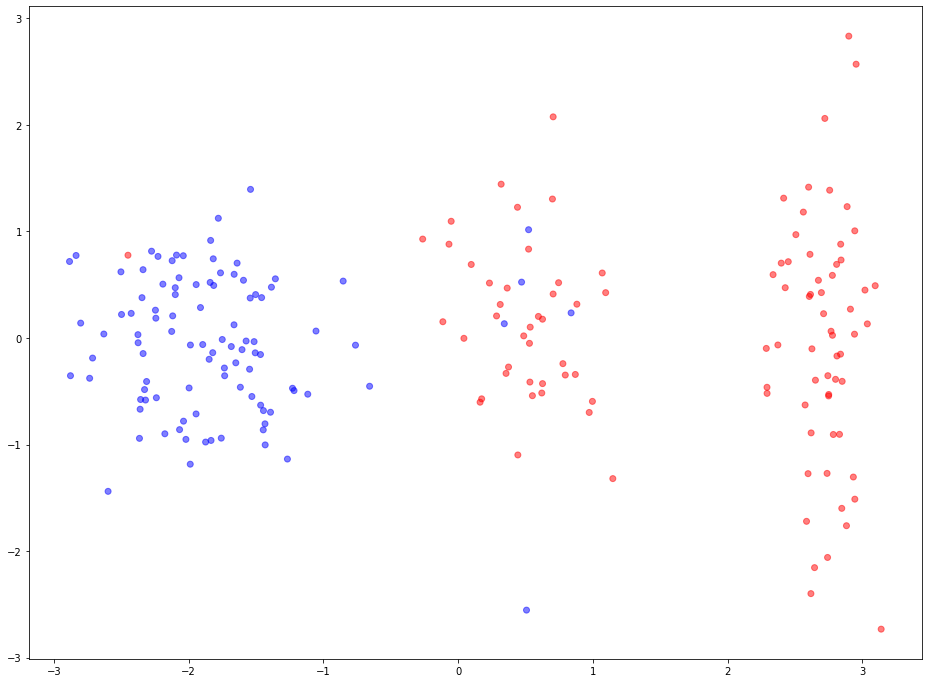

In [ ]:
node2vec_result = train_and_evaluate(node2vec_embedding, "Node2Vec")